In [4]:

# Loading the necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from mlxtend.evaluate import bias_variance_decomp
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")
%matplotlib inline


In [5]:
# Load the datasets
house_price_index = pd.read_csv('CSUSHPISA.csv')
population = pd.read_csv('Population.csv')
house_supply = pd.read_csv('Housing_Supply.csv')
gdp = pd.read_csv('GDP.csv')
mortgage = pd.read_csv('MORTGAGE.csv')
employment_rate = pd.read_csv('Employment_rate.csv')

In [6]:
# Convert the 'DATE' column in each dataset to the desired format "yyyy-mm-dd"
population['DATE'] = pd.to_datetime(population['DATE'], format='%d-%m-%Y').dt.strftime('%Y-%m-%d')
house_supply['DATE'] = pd.to_datetime(house_supply['DATE'], format='%d-%m-%Y').dt.strftime('%Y-%m-%d')
gdp['DATE'] = pd.to_datetime(gdp['DATE'], format='%d-%m-%Y').dt.strftime('%Y-%m-%d')
employment_rate['DATE'] = pd.to_datetime(employment_rate['DATE'], format='%d-%m-%Y').dt.strftime('%Y-%m-%d')

In [7]:
# Merge the datasets based on 'DATE' using an inner join
merged_df = house_price_index.merge(population, on='DATE', how='inner')
merged_df = merged_df.merge(house_supply, on='DATE', how='inner')
merged_df = merged_df.merge(gdp, on='DATE', how='inner')
merged_df = merged_df.merge(mortgage, on='DATE', how='inner')
merged_df = merged_df.merge(employment_rate, on='DATE', how='inner')

In [9]:
# Transform the target variable 'CSUSHPISA' using log transformation
merged_df['CSUSHPISA'] = np.log1p(merged_df['CSUSHPISA'])

print(merged_df.shape)
print('=' * 20)
print(merged_df.info())
print('=' * 20)
print(merged_df.describe())

(437, 7)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 437 entries, 0 to 436
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DATE             437 non-null    object 
 1   CSUSHPISA        437 non-null    float64
 2   Population       437 non-null    int64  
 3   Housing_supply   437 non-null    float64
 4   GDP              437 non-null    float64
 5   MORTGAGE30US     437 non-null    object 
 6   Employment_rate  437 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 27.3+ KB
None
        CSUSHPISA     Population  Housing_supply         GDP  Employment_rate
count  437.000000     437.000000      437.000000  437.000000       437.000000
mean     1.766577  293157.677346        5.893822   99.960292        65.124943
std      0.071007   28662.256331        1.742516    1.094523         1.782701
min      1.643617  241857.000000        3.300000   91.635065        60.100000
25%      1.6897

In [10]:
# Convert the 'DATE' column to datetime format
merged_df['DATE'] = pd.to_datetime(merged_df['DATE'])

# Convert the 'MORTGAGE30US' column to float
merged_df['MORTGAGE30US'] = merged_df['MORTGAGE30US'].astype(float)

In [11]:
# Define the column with potential outliers ('CSUSHPISA')
column_name = 'CSUSHPISA'

# Calculate the IQR (Interquartile Range)
Q1 = merged_df[column_name].quantile(0.25)
Q3 = merged_df[column_name].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = merged_df[(merged_df[column_name] < lower_bound) | (merged_df[column_name] > upper_bound)]

# Display the number of outliers and example rows
print("Number of outliers:", len(outliers))
print("Example outlier rows:")
print(outliers)

Number of outliers: 0
Example outlier rows:
Empty DataFrame
Columns: [DATE, CSUSHPISA, Population, Housing_supply, GDP, MORTGAGE30US, Employment_rate]
Index: []


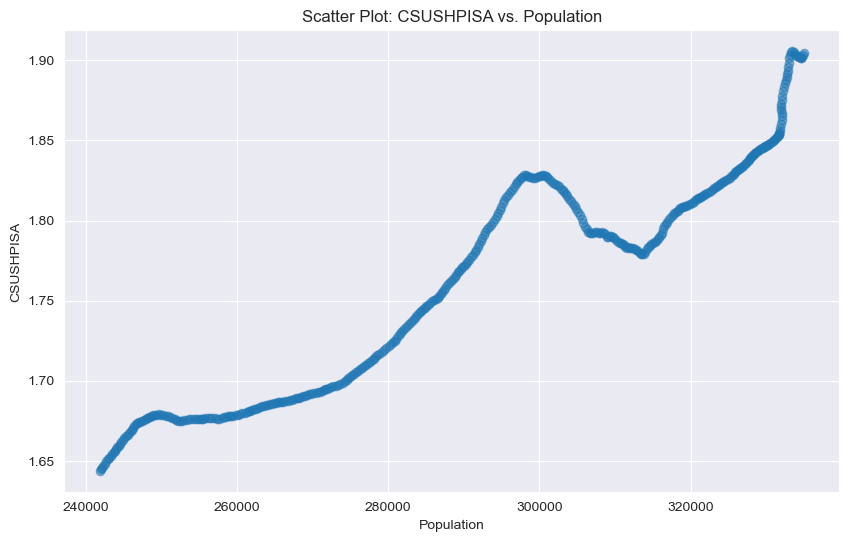

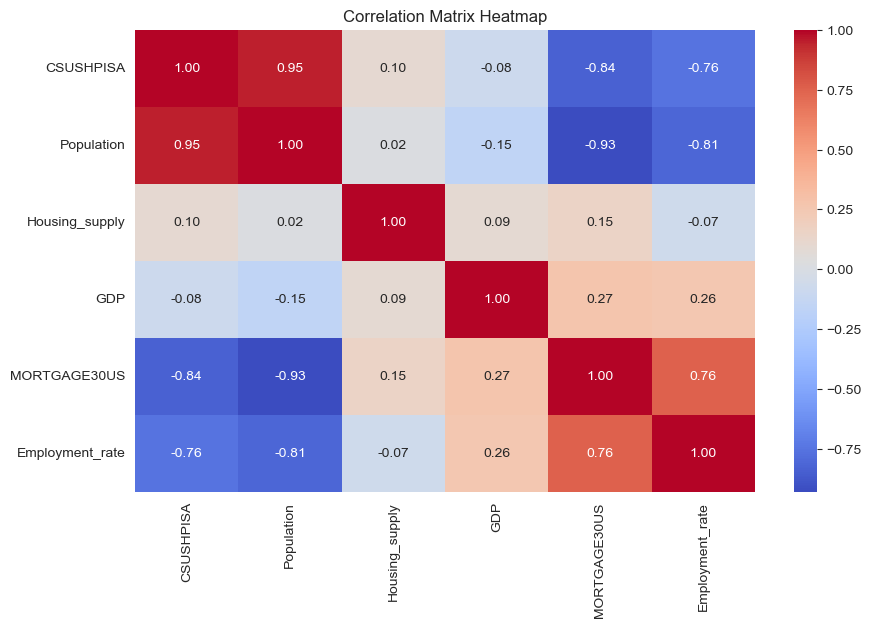

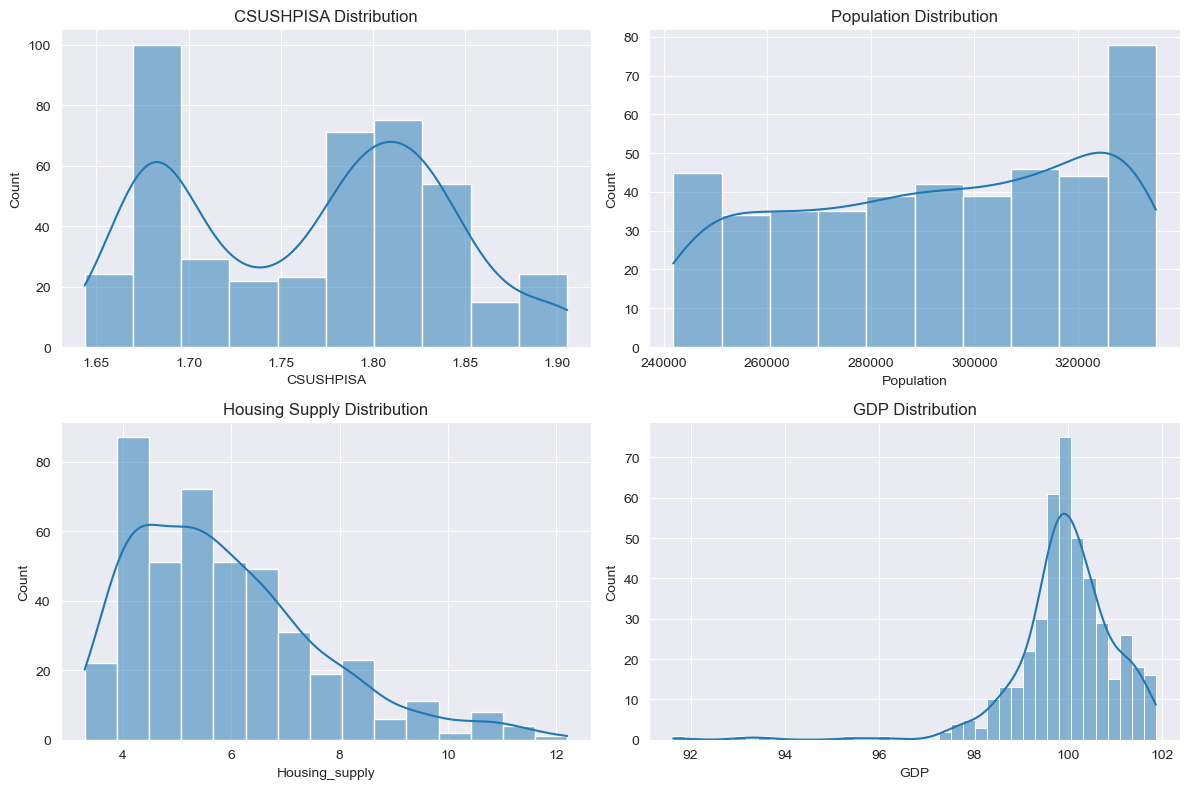

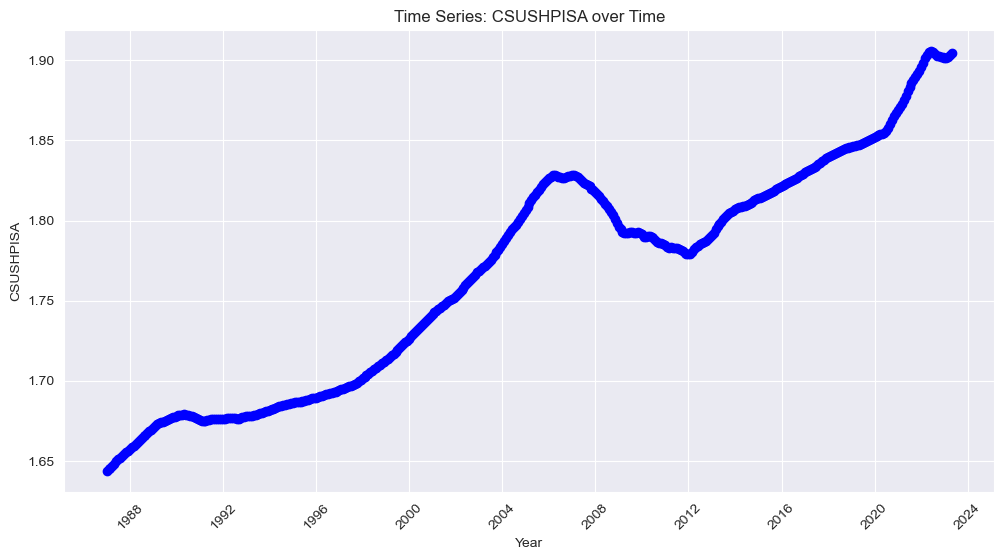

In [12]:
#scatter plot 
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Population'], merged_df['CSUSHPISA'], alpha=0.5)
plt.title('Scatter Plot: CSUSHPISA vs. Population')
plt.xlabel('Population')
plt.ylabel('CSUSHPISA')
plt.show()

#correlation matrix 
correlation_matrix = merged_df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

#Distribution plot 
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.histplot(merged_df['CSUSHPISA'], kde=True)
plt.title('CSUSHPISA Distribution')

plt.subplot(2, 2, 2)
sns.histplot(merged_df['Population'], kde=True)
plt.title('Population Distribution')

plt.subplot(2, 2, 3)
sns.histplot(merged_df['Housing_supply'], kde=True)
plt.title('Housing Supply Distribution')

plt.subplot(2, 2, 4)
sns.histplot(merged_df['GDP'], kde=True)
plt.title('GDP Distribution')

plt.tight_layout()
plt.show()

#time series plot 
plt.figure(figsize=(12, 6))
plt.plot(merged_df['DATE'], merged_df['CSUSHPISA'], marker='o', linestyle='-', color='b')
plt.title('Time Series: CSUSHPISA over Time')
plt.xlabel('Year')
plt.ylabel('CSUSHPISA')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [13]:
# Define the features (X) and target variable (y)
# Exclude the 'DATE' column from the features
X = merged_df.drop(columns=['CSUSHPISA', 'DATE'])
y = merged_df['CSUSHPISA']

# Min-Max scaling transformation for feature columns
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

In [14]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print("Training set shape (X, y):", X_train.shape, y_train.shape)
print("Testing set shape (X, y):", X_test.shape, y_test.shape)

Training set shape (X, y): (349, 5) (349,)
Testing set shape (X, y): (88, 5) (88,)


In [16]:
#Create a list of models to explore
models = [
    LinearRegression(),
    Lasso(),
    Ridge(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# Train and evaluate each model
for model in models:
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions
    mse = mean_squared_error(y_test, y_pred)  # Calculate Mean Squared Error
    r2 = r2_score(y_test, y_pred)  # Calculate R-squared
    print(f"Model: {model.__class__.__name__}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R-squared: {r2:.2f}")
    print("=" * 30)

Model: LinearRegression
Mean Squared Error: 0.00
R-squared: 0.94
Model: Lasso
Mean Squared Error: 0.01
R-squared: -0.02
Model: Ridge
Mean Squared Error: 0.00
R-squared: 0.93
Model: RandomForestRegressor
Mean Squared Error: 0.00
R-squared: 1.00
Model: GradientBoostingRegressor
Mean Squared Error: 0.00
R-squared: 1.00


In [17]:
# Create a RandomForestRegressor with regularization parameters
rfr = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Train the model
rfr.fit(X_train, y_train)

# Evaluate the model
y_pred_rfr = rfr.predict(X_test)
mse_rfr = mean_squared_error(y_test, y_pred_rfr)
r2_rfr = r2_score(y_test, y_pred_rfr)
print("Random Forest Regressor (Regularized)")
print("Mean Squared Error:", mse_rfr)
print("R-squared:", r2_rfr)

Random Forest Regressor (Regularized)
Mean Squared Error: 4.727759166499217e-06
R-squared: 0.9992031114656408


In [18]:
gbr = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)

# Train the model
gbr.fit(X_train, y_train)

# Evaluate the model
y_pred_gbr = gbr.predict(X_test)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)
print("Gradient Boosting Regressor (Regularized)")
print("Mean Squared Error:", mse_gbr)
print("R-squared:", r2_gbr)


Gradient Boosting Regressor (Regularized)
Mean Squared Error: 4.631710896754619e-06
R-squared: 0.9992193009038522


        DATE  CSUSHPISA  Population  Housing_supply        GDP  MORTGAGE30US  \
0 1987-01-01   1.643617      241857             6.0  99.895819        9.2040   
1 1987-02-01   1.644977      242005             6.2  99.868262        9.0825   
2 1987-03-01   1.645892      242166             6.0  99.861993        9.0350   
3 1987-04-01   1.647049      242338             6.0  99.874625        9.8325   
4 1987-05-01   1.648303      242516             6.7  99.903546       10.5960   

   Employment_rate  
0             65.4  
1             65.5  
2             65.5  
3             65.4  
4             65.7  
          DATE  CSUSHPISA  Population  Housing_supply         GDP  \
432 2023-01-01   1.901474      334533             8.1   99.984928   
433 2023-02-01   1.901653      334637             8.4  100.013852   
434 2023-03-01   1.902279      334753             8.1  100.042616   
435 2023-04-01   1.903274      334880             7.6  100.072500   
436 2023-05-01   1.904478      335013           